# **Particle-Swarm Optimization**

## Bio-Inspired Computing
### Mikel Ignacio Barajas Martínez

### 08/27/24

𝝮

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

In [2]:
def parabola(x):
    return np.sum(x**2, axis=1)

def rastrigin(x):
    A = 10
    X = np.atleast_2d(x) # accept both one-individual and population inputs
    n = X.shape[1]
    return A * n + np.sum(X**2 - A * np.cos(2 * np.pi * X), axis=1).squeeze()

In [3]:
class PSO:
    def __init__(self, n, dim, iterations, c1, c2, w_max, w_min, f, lower_bound=-5.12, upper_bound=5.12):
        
        # problem parameters
        self.n = n
        self.dim = dim
        self.iterations = iterations
        self.true_iterations = iterations
        self.tolerance = 1
        self.min_tolerance = 1e-6
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound

        # acceleration coefficients
        self.c1 = c1
        self.c2 = c2

        # inertia weight
        self.w_max = w_max
        self.w_min = w_min

        # objective function
        self.f = f

        # particle data
        self.p = None
        self.v = None
        self.p_best_positions = None
        self.p_best_values = None
        self.g_best_position = None
        self.g_best_value = np.inf

        # history
        self.p_history = []
        self.v_history = []
        self.g_best_history = []

        # plots
        self.history = []
        self.p_plot = None
        self.v_plot = None
        self.g_best_plot = None


    def setup(self):

        # initialize particles
        self.p = np.random.uniform(self.lower_bound, self.upper_bound, (self.n, self.dim))
        self.v = np.random.uniform(-1, 1, (self.n, self.dim))

        # initialize personal best positions
        self.p_best_positions = self.p.copy()
        self.p_best_values = self.f(self.p)

        # initialize global best position
        self.g_best_position = self.p_best_positions[self.p_best_values.argmin()]
        self.g_best_value = self.p_best_values.min()

        self.tolerance = 1
    
    def update(self, i):

        # update velocity
        w = self.w_max - (self.w_max - self.w_min) * i / self.iterations
        r1 = np.random.uniform(0, 1, (self.n, self.dim))
        r2 = np.random.uniform(0, 1, (self.n, self.dim))
        self.v = w * self.v + self.c1 * r1 * (self.p_best_positions - self.p) + self.c2 * r2 * (self.g_best_position - self.p)

        # update position
        self.p = self.p + self.v

        # apply boundary conditions
        self.p = np.clip(self.p, self.lower_bound, self.upper_bound)

        # update personal best
        values = self.f(self.p)
        mask = values < self.p_best_values
        self.p_best_positions[mask] = self.p[mask]
        self.p_best_values[mask] = values[mask]

        # tolerance
        if i > self.iterations / 2:
            self.tolerance = abs(self.p_best_values.min() - self.g_best_value);

        # update global best
        if self.p_best_values.min() < self.g_best_value:
            self.g_best_position = self.p_best_positions[self.p_best_values.argmin()]
            self.g_best_value = self.p_best_values.min()

        self.history.append(self.g_best_value)
        self.p_history.append(self.p.copy())
        self.v_history.append(self.v.copy())
        self.g_best_history.append(self.g_best_position)

    def run(self):

        for i in range(self.iterations):
            self.update(i)

            if self.tolerance < self.min_tolerance:
                self.true_iterations = i
                break

            yield i, self.g_best_position, self.g_best_value


    def optimize(self, verbose=True):

        self.setup()

        print(f'PSO with parameters n={self.n}, ite={self.iterations}, c1={self.c1}, c2={self.c2}, wmax={self.w_max}, wmin={self.w_min}')

        start_time = time.time()
        for i, g_best_position, g_best_value in self.run():
            if verbose:
                print(f'Iteration {i + 1}: {g_best_value} ({g_best_position})')
                
        print(f'Time taken: {time.time() - start_time:.6f} seconds')
        print(f'Global best value: {self.g_best_value} at {self.g_best_position}')

    def __lt__(self, other):
        return self.g_best_value > other.g_best_value

    def plot_convergence(self):

        plt.plot(self.history)
        plt.xlabel('Iteration')
        plt.ylabel('Best f-Value')
        plt.show()

    def animate(self, i):

        self.p_plot.set_offsets(self.p_history[i])
        self.v_plot.set_offsets(self.p_history[i])
        self.v_plot.set_UVC(self.v_history[i][:, 0], self.v_history[i][:, 1])
        # self.g_best_plot.set_offsets([g_best_position_history[i]])
        return self.p_plot, self.v_plot #, self.g_best_plot

    def plot_animation(self, format='mp4', fps=15, save=True, filename='pso'):

        x1, x2 = np.meshgrid(np.linspace(self.lower_bound, self.upper_bound, 100), np.linspace(self.lower_bound, self.upper_bound, 100))
        X = np.column_stack((x1.ravel(), x2.ravel()))
        Z = self.f(X).reshape(x1.shape)
        
        fig, ax = plt.subplots()

        contour = ax.contourf(x1, x2, Z, levels=100, cmap='coolwarm')
        CS = ax.contour(x1, x2, Z, levels=10, colors='white', linewidths=0.5, alpha=0.7)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')

        fig.colorbar(contour, ax=ax)

        ax.set_aspect('equal', adjustable='box')

        self.p_plot = ax.scatter(self.p[:, 0], self.p[:, 1], color='black', animated=True, alpha=0.5)
        self.v_plot = ax.quiver(self.p[:, 0], self.p[:, 1], self.v[:, 0], self.v[:, 1], color='black', alpha=0.7, width=0.005, angles='xy', scale_units='xy', scale=1, animated=True)
        # g_best_plot = ax.scatter(g_best_position[0], g_best_position[1], color='red', marker='x', label='global best', alpha=0.7, animated=True)

        anim = FuncAnimation(fig, self.animate, frames=self.true_iterations, interval=100, blit=True, repeat=True)

        self.min_plot = ax.scatter(0, 0, color='black', marker='*', label='true minimum', alpha=0.7)

        # plt.legend()

        if save:
            if format == 'gif':
                anim.save(f'{filename}.gif', writer='imagemagick', fps=fps)
            else:
                anim.save(f'{filename}.{format}', writer='ffmpeg', fps=fps)

        plt.show()

    def plot_frame(self, i):

        x1, x2 = np.meshgrid(np.linspace(self.lower_bound, self.upper_bound, 100), np.linspace(self.lower_bound, self.upper_bound, 100))
        X = np.column_stack((x1.ravel(), x2.ravel()))
        Z = self.f(X).reshape(x1.shape)
        
        fig, ax = plt.subplots()

        contour = ax.contourf(x1, x2, Z, levels=100, cmap='coolwarm')
        CS = ax.contour(x1, x2, Z, levels=10, colors='white', linewidths=0.5, alpha=0.7)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')

        fig.colorbar(contour, ax=ax)

        ax.set_aspect('equal', adjustable='box')

        p_plot = ax.scatter(self.p_history[i][:, 0], self.p_history[i][:, 1], color='black', alpha=0.5)
        v_plot = ax.quiver(self.p_history[i][:, 0], self.p_history[i][:, 1], self.v_history[i][:, 0], self.v_history[i][:, 1], color='black', alpha=0.7, width=0.005, angles='xy', scale_units='xy', scale=1)
        g_best_plot = ax.scatter(self.g_best_history[i][0], self.g_best_history[i][1], color='red', marker='x', label='global best', alpha=0.7)
        min_plot = ax.scatter(0, 0, color='black', marker='*', label='true minimum', alpha=0.7)

        plt.title(f'Iteration {i + 1}')
        plt.legend(loc='lower left')

        plt.show

    def plot_objective_function(self):

        x1, x2 = np.meshgrid(np.linspace(self.lower_bound, self.upper_bound, 100), np.linspace(self.lower_bound, self.upper_bound, 100))
        X = np.column_stack((x1.ravel(), x2.ravel()))

        Z = self.f(X).reshape(x1.shape)

        # 3D plot

        fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
        ax.plot_surface(x1, x2, Z, cmap='coolwarm')

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('f(x1, x2)')

        offset = Z.min()
        contour = ax.contour(x1, x2, Z, zdir='z', offset=offset, linewidths=0.4, levels=10, cmap='coolwarm')

        ax.view_init(elev=20, azim=45)
        ax.set_box_aspect([2, 2, 1])

        plt.show()

        # 2D contour plot

        fig, ax = plt.subplots()

        contour = ax.contourf(x1, x2, Z, levels=100, cmap='coolwarm')
        CS = ax.contour(x1, x2, Z, levels=10, colors='white', linewidths=0.5, alpha=0.7)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')

        fig.colorbar(contour, ax=ax)

        ax.set_aspect('equal', adjustable='box')

        plt.show()



PSO with parameters n=100, ite=200, c1=0.1, c2=0.1, wmax=0.9, wmin=0.4
Iteration 1: 33.2904406372697 ([ 0.17151162 -0.31567347  2.57507325 -1.82133099 -2.52359698 -1.03241858
 -0.86497412  0.6183162  -2.43929017 -2.94924809])
Iteration 2: 29.701894359325223 ([ 1.13780399  2.20017902 -1.04873517  0.51657984 -0.4996618  -1.40058218
  0.42816806 -0.43622421 -3.34468176  2.9031019 ])
Iteration 3: 26.070775305160826 ([ 1.32543317  0.61816581 -3.36058117  0.54244081  2.36098247 -0.30697264
 -0.35989554 -1.15763944 -2.27497525 -0.17461026])
Iteration 4: 15.313058443243937 ([-1.81370486  0.6374369   1.59762209 -0.59500221 -1.25587361  1.25463048
 -1.33239917 -0.69071237  1.63970831 -0.78641765])
Iteration 5: 14.799366020017803 ([-1.80075621  1.32030979  1.0731812   0.13852485 -0.94615692  0.41652052
 -2.34058923  0.19982344  1.41854803  0.20796646])
Iteration 6: 11.905306232478088 ([-0.01663067  0.56185468 -1.5888301   0.72606666 -1.56032329 -1.05361306
  1.26452598 -1.27865194  1.27150699 -0.

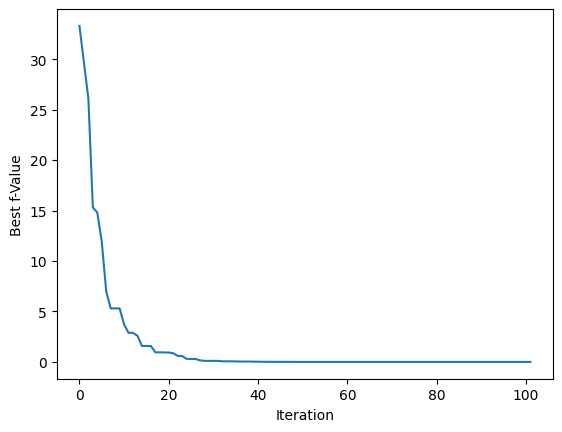

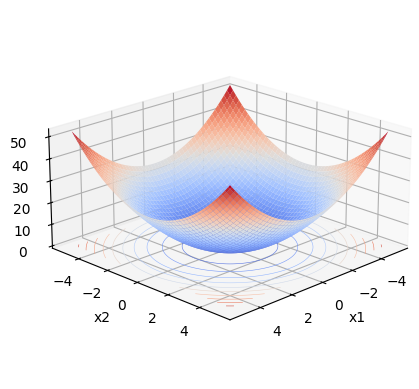

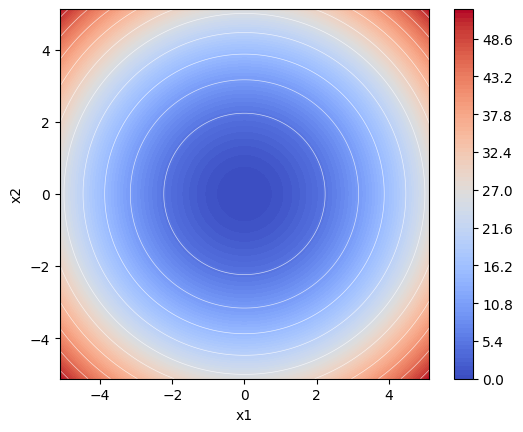

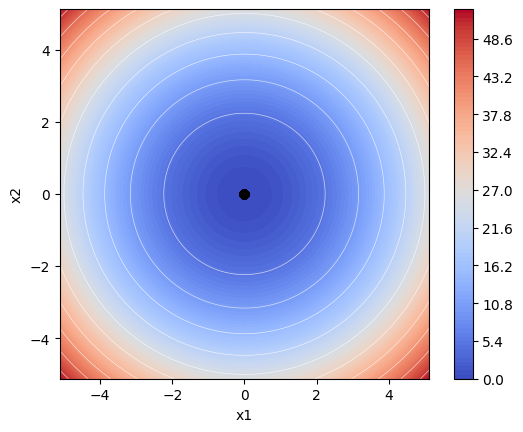

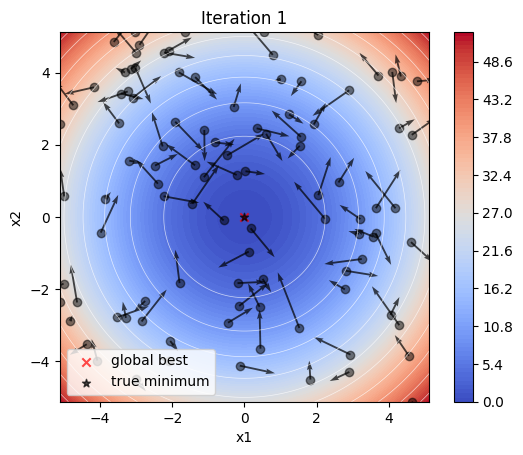

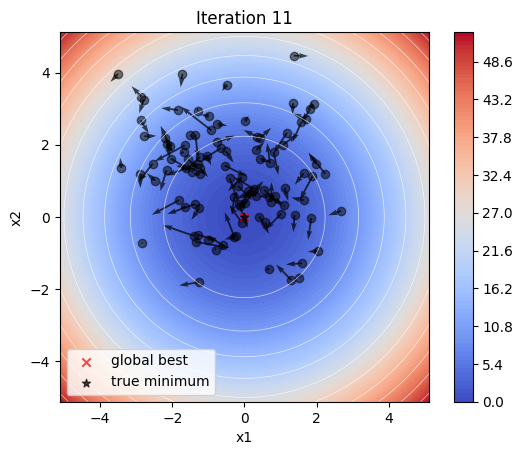

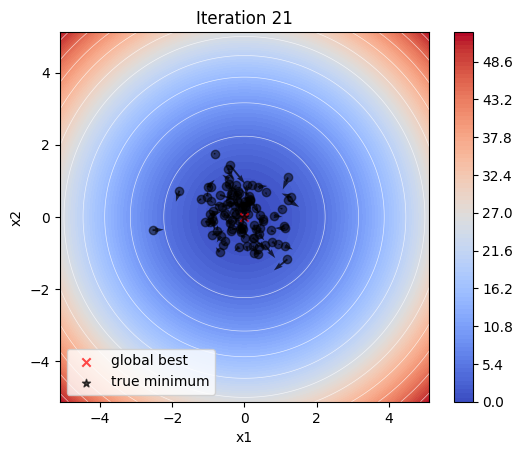

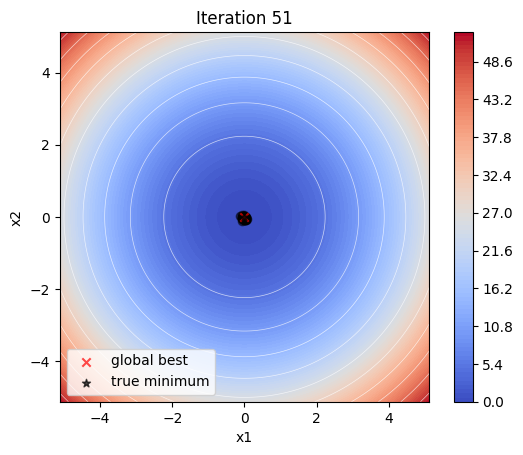

In [4]:
pso = PSO(n=100, dim=10, iterations=200, c1=0.1, c2=0.1, w_max=0.9, w_min=0.4, f=parabola)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='parabola')
pso.plot_frame(0)
pso.plot_frame(10)
pso.plot_frame(20)
pso.plot_frame(50)

PSO with parameters n=100, ite=200, c1=0.1, c2=0.1, wmax=0.9, wmin=0.4
Iteration 1: 105.02888440912724 ([ 1.15038674 -4.22940769  2.74841276  0.13471889  2.23511563 -0.86606996
  2.16471187  0.12840638 -3.21774324 -1.09022341])
Iteration 2: 78.08487893004063 ([-0.04327458 -1.97364242  1.03155679  1.92797451  1.28891578 -1.92079323
  1.9264073  -3.21747315  1.52954841 -0.13623129])
Iteration 3: 78.08487893004063 ([-0.04327458 -1.97364242  1.03155679  1.92797451  1.28891578 -1.92079323
  1.9264073  -3.21747315  1.52954841 -0.13623129])
Iteration 4: 78.08487893004063 ([-0.04327458 -1.97364242  1.03155679  1.92797451  1.28891578 -1.92079323
  1.9264073  -3.21747315  1.52954841 -0.13623129])
Iteration 5: 78.08487893004063 ([-0.04327458 -1.97364242  1.03155679  1.92797451  1.28891578 -1.92079323
  1.9264073  -3.21747315  1.52954841 -0.13623129])
Iteration 6: 77.53459504540747 ([-2.01060927 -1.26025622  0.98291014  0.4205835  -2.95918115 -1.94007169
  2.9518241   0.05878311  2.22648393 -1.944

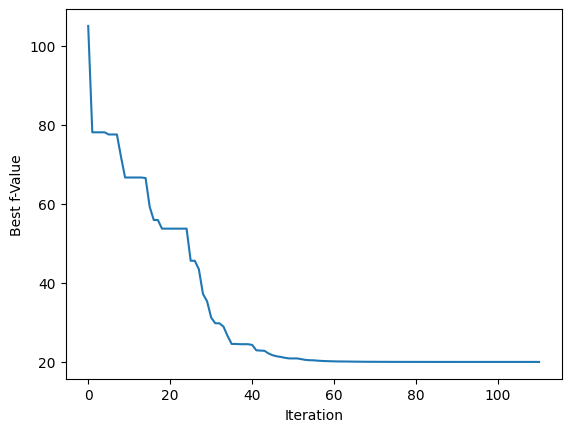

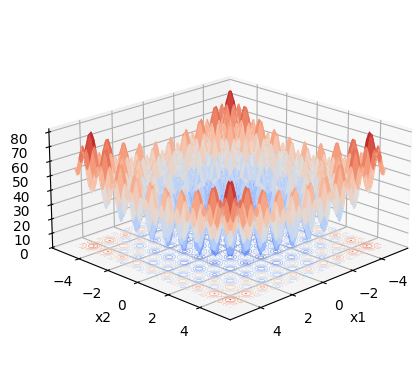

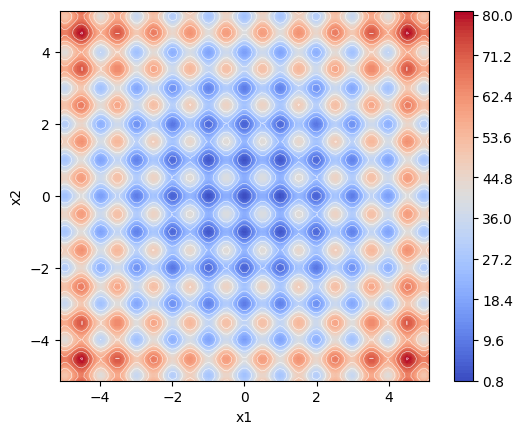

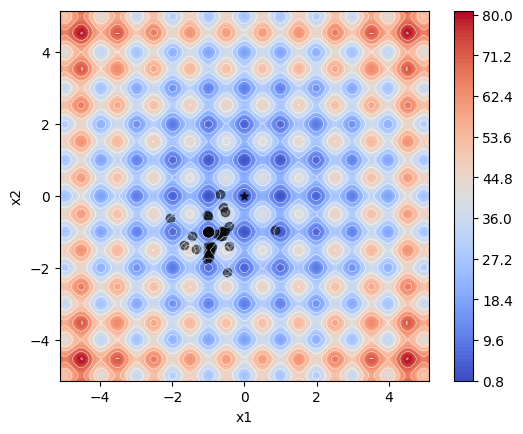

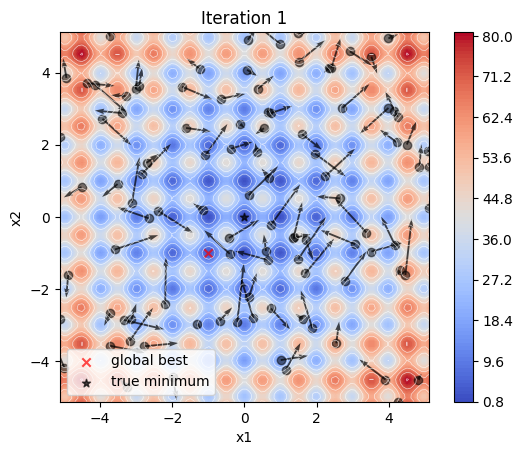

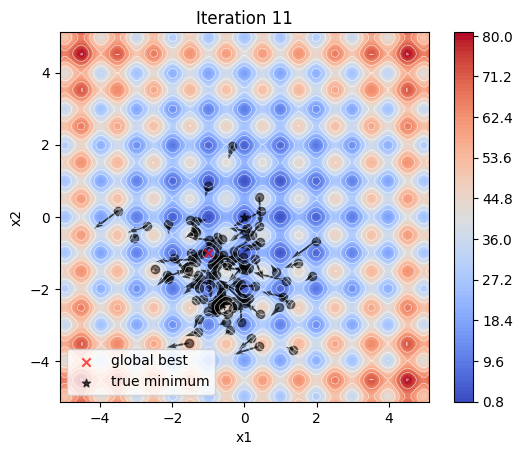

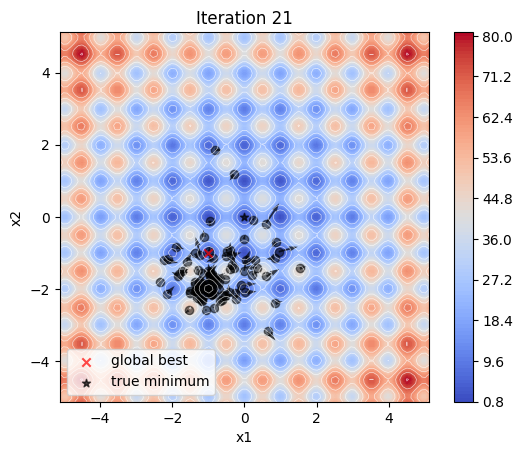

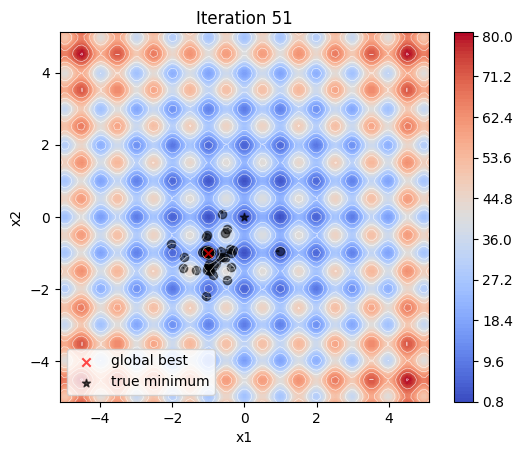

In [5]:
pso = PSO(n=100, dim=10, iterations=200, c1=0.1, c2=0.1, w_max=0.9, w_min=0.4, f=rastrigin)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='rastrigin')
pso.plot_frame(0)
pso.plot_frame(10)
pso.plot_frame(20)
pso.plot_frame(50)

MovieWriter imagemagick unavailable; using Pillow instead.


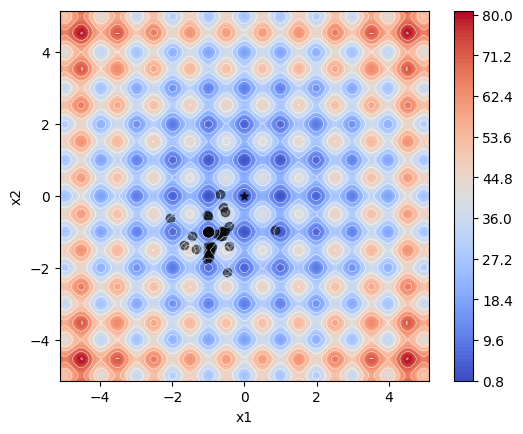

In [6]:
pso.plot_animation(format='gif', filename='rastrigingif')

In [7]:
import heapq

possible_n = [10, 100, 1000]
possible_iterations = [100, 200, 500]
possible_c1 = [0.1, 0.5, 1]
possible_c2 = [0.1, 0.5, 1]
possible_w_max = [0.9, 0.5, 0.1]
possible_w_min = [0.4, 0.2, 0.1]

best_runs = []

for n in possible_n:
    for iterations in possible_iterations:
        for c1 in possible_c1:
            for c2 in possible_c2:
                for w_max in possible_w_max:
                    for w_min in possible_w_min:
                        pso = PSO(n=n, dim=10, iterations=iterations, c1=c1, c2=c2, w_max=w_max, w_min=w_min, f=rastrigin)
                        pso.optimize(verbose=False)
                        heapq.heappush(best_runs, pso)
                        if len(best_runs) > 3:
                            heapq.heappop(best_runs)    

PSO with parameters n=10, ite=100, c1=0.1, c2=0.1, wmax=0.9, wmin=0.4
Time taken: 0.006430 seconds
Global best value: 68.60587426493156 at [-0.78384698 -1.41938653 -0.91277393 -0.23100682 -0.1583703   1.98508082
 -0.01550219 -2.1263977  -2.85538437  0.01616045]
PSO with parameters n=10, ite=100, c1=0.1, c2=0.1, wmax=0.9, wmin=0.2
Time taken: 0.003251 seconds
Global best value: 49.233812422767414 at [ 0.79669749  0.17867237  0.2122625   1.68202494  0.11256111  0.99973014
 -0.02940615  2.07149722  1.04725411  0.06084497]
PSO with parameters n=10, ite=100, c1=0.1, c2=0.1, wmax=0.9, wmin=0.1
Time taken: 0.004343 seconds
Global best value: 67.6834604154227 at [ 1.03348579 -2.03993515  1.93746841 -0.06026219 -0.24884914  2.71639582
 -3.24042236 -1.05522658 -2.046787    1.0007906 ]
PSO with parameters n=10, ite=100, c1=0.1, c2=0.1, wmax=0.5, wmin=0.4
Time taken: 0.002517 seconds
Global best value: 72.30563331800684 at [ 0.10207818  1.26714644 -1.0711917   1.70313881  1.99714358 -1.91501227
  

Third best: 0.9952076897711919 at [-9.95174570e-01 -3.70325389e-04  2.15374288e-04  1.42241235e-04
 -1.67749973e-05 -6.96661072e-04 -4.76973665e-04  7.27127933e-05
  5.23422039e-04  1.02452488e-04]
with parameters n=1000, ite=200, c1=1, c2=0.5, wmax=0.9, wmin=0.4


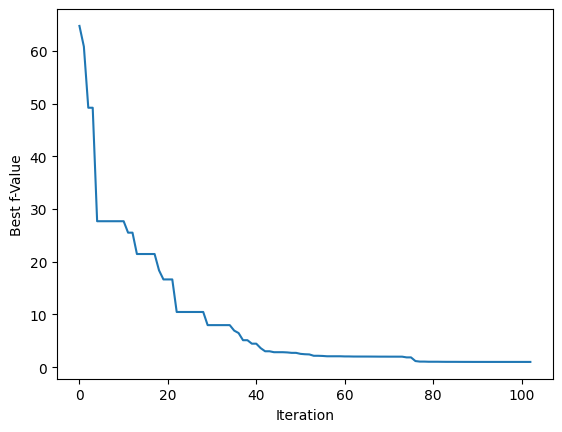

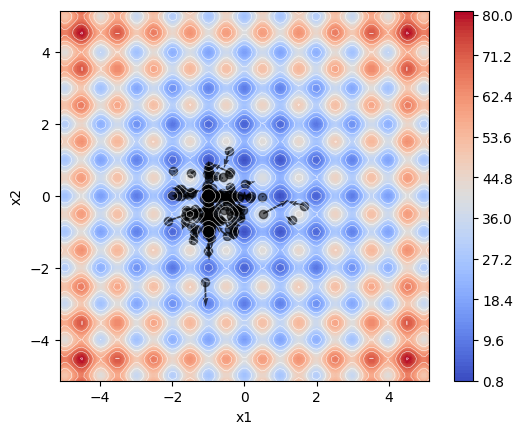

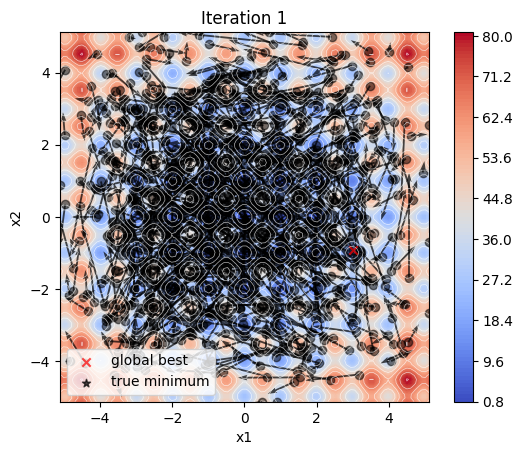

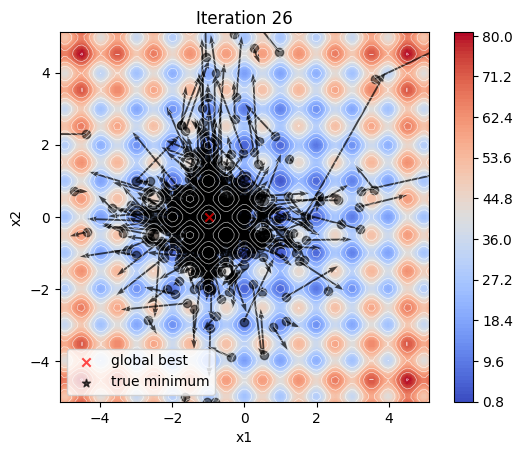

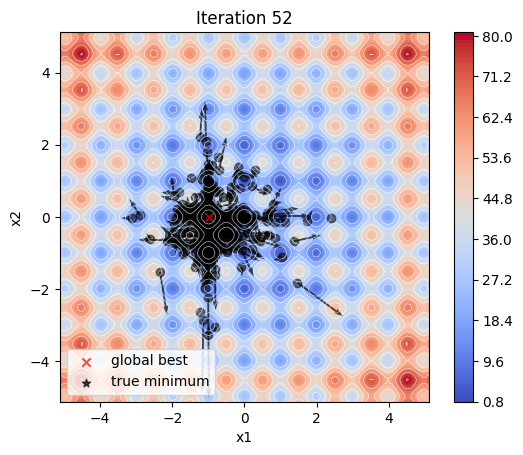

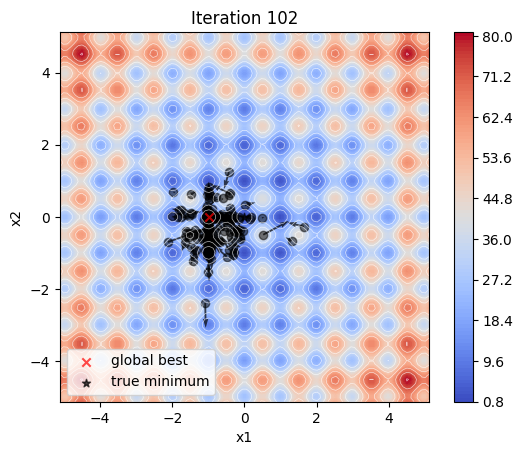

In [8]:
pso = heapq.heappop(best_runs)

print(f'Third best: {pso.g_best_value} at {pso.g_best_position}') 
print(f'with parameters n={pso.n}, ite={pso.iterations}, c1={pso.c1}, c2={pso.c2}, wmax={pso.w_max}, wmin={pso.w_min}')

pso.plot_convergence()

pso.plot_animation(filename='rastrigin_run_3')

pso.plot_frame(0)
pso.plot_frame(pso.true_iterations // 4)
pso.plot_frame(pso.true_iterations // 2)
pso.plot_frame(pso.true_iterations - 1)

Second best: 0.9949590571032019 at [ 2.49291755e-10  5.98060544e-08  3.93153476e-08 -1.98300684e-08
 -1.43048050e-08 -4.84661603e-08  3.90704162e-08  1.94050030e-07
 -3.82706700e-08  9.94958602e-01]
with parameters n=1000, ite=500, c1=1, c2=1, wmax=0.9, wmin=0.4


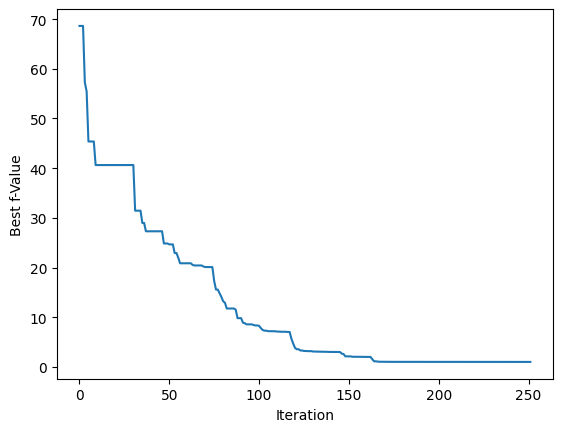

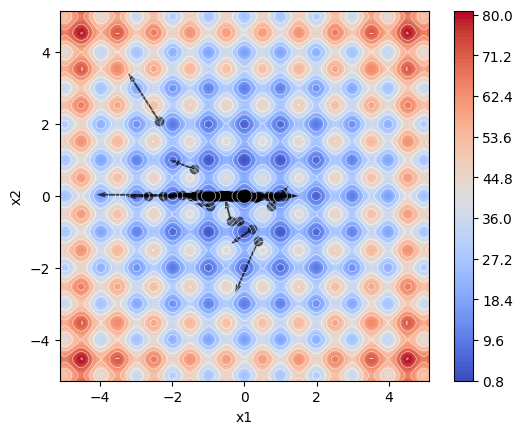

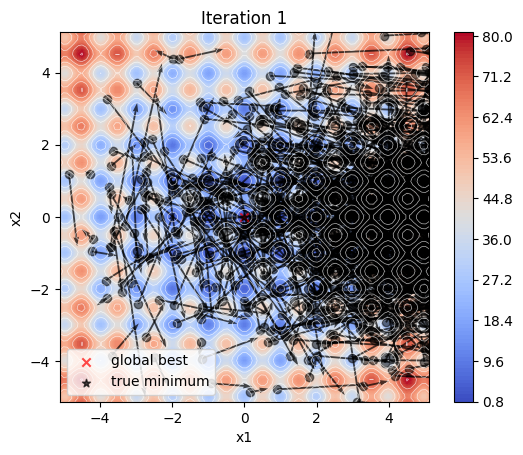

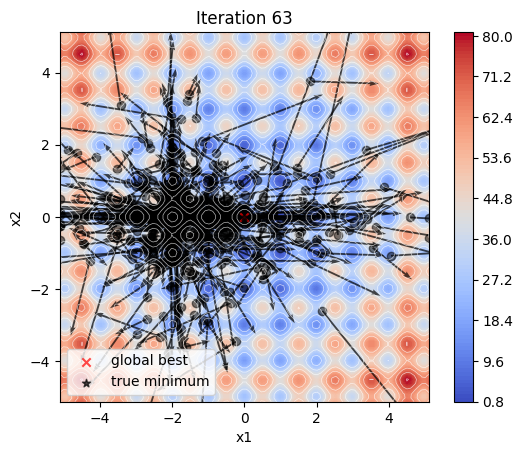

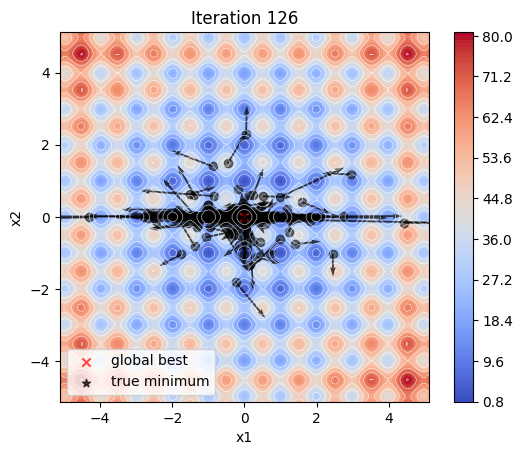

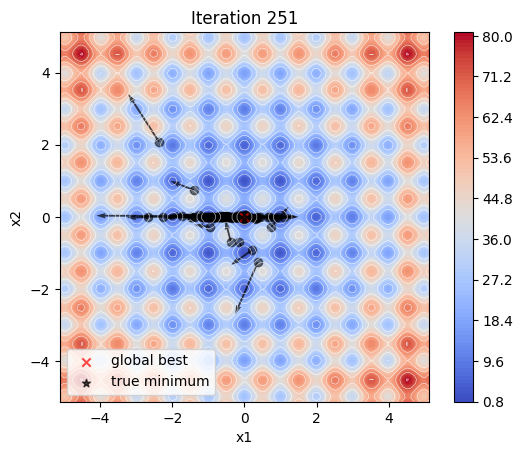

In [9]:
pso = heapq.heappop(best_runs)

print(f'Second best: {pso.g_best_value} at {pso.g_best_position}')
print(f'with parameters n={pso.n}, ite={pso.iterations}, c1={pso.c1}, c2={pso.c2}, wmax={pso.w_max}, wmin={pso.w_min}')

pso.plot_convergence()

pso.plot_animation(filename='rastrigin_run_2')

pso.plot_frame(0)
pso.plot_frame(pso.true_iterations // 4)
pso.plot_frame(pso.true_iterations // 2)
pso.plot_frame(pso.true_iterations - 1)

Best: 0.0 at [ 3.22768926e-09  2.31947344e-09  8.62545460e-10  2.16889181e-09
 -2.32774418e-09 -5.18235001e-09 -3.53122721e-09  5.74739762e-10
  5.60851211e-09 -2.81022142e-10]
with parameters n=1000, ite=500, c1=1, c2=1, wmax=0.9, wmin=0.1


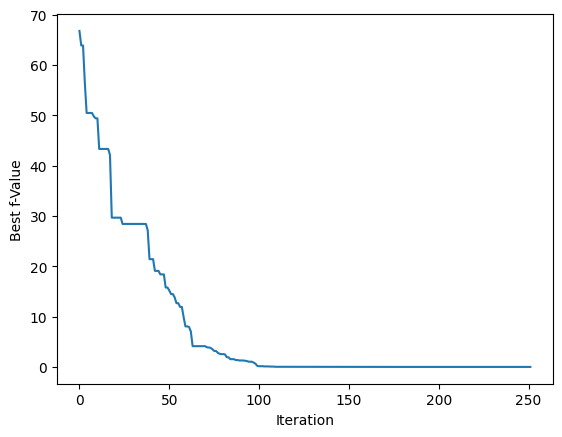

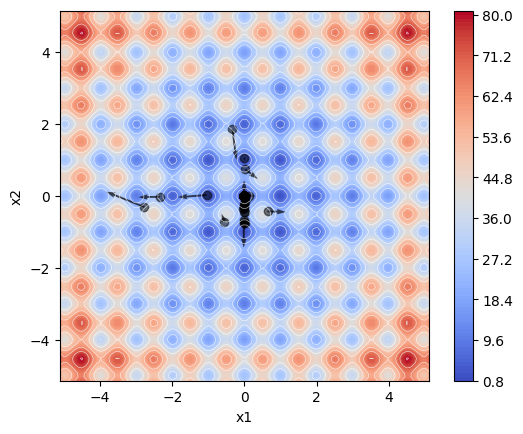

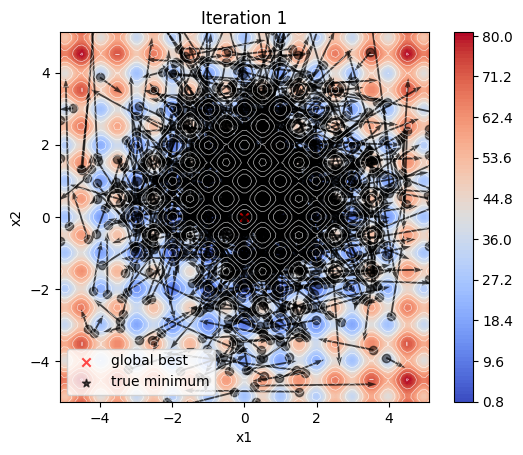

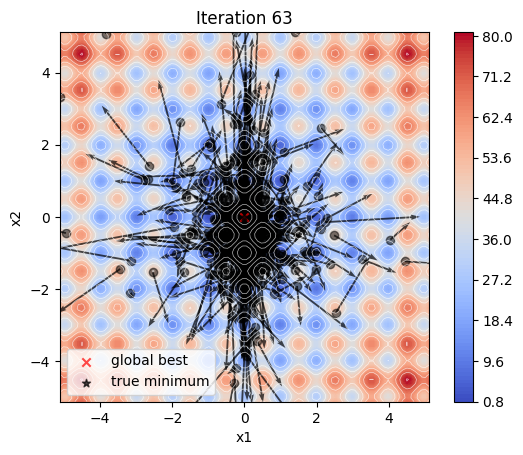

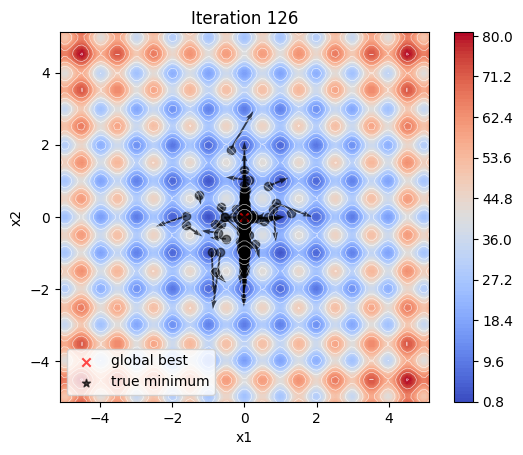

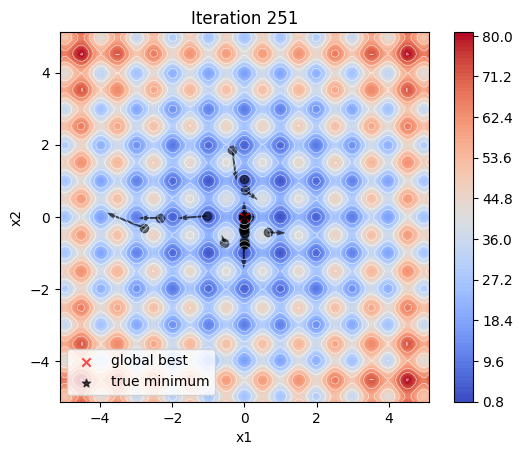

In [10]:
pso = heapq.heappop(best_runs)

print(f'Best: {pso.g_best_value} at {pso.g_best_position}')
print(f'with parameters n={pso.n}, ite={pso.iterations}, c1={pso.c1}, c2={pso.c2}, wmax={pso.w_max}, wmin={pso.w_min}')

pso.plot_convergence()

pso.plot_animation(filename='rastrigin_run_1')

pso.plot_frame(0)
pso.plot_frame(pso.true_iterations // 4)
pso.plot_frame(pso.true_iterations // 2)
pso.plot_frame(pso.true_iterations - 1)